In [1]:
import torch
from tqdm import tqdm
import numpy as np
import sys
import matplotlib.pyplot as plt
import importlib
import pandas as pd
from scipy.stats import norm 

from utils import checkpoint, warning
import utils
import MCHMC, MCLMC
import autotuning as aut
import integration_schemes as integ
import functions as funct
import metrics

np.random.seed(0)

In [2]:
importlib.reload(utils)
importlib.reload(MCHMC)
importlib.reload(MCLMC)
importlib.reload(aut)
importlib.reload(integ)
importlib.reload(funct)
importlib.reload(metrics);

## Global parameter optimization

In [3]:
fn = funct.ill_cond_gaussian
d = 100
n_chains = 5

'''
cov = funct.get_ill_cov(d)
np.savetxt('gaussian_cov.csv', cov, delimiter=',', fmt='%d')
'''
cov = np.loadtxt('gaussian_cov.csv', delimiter=',')

In [ ]:
# create a csv file with the optimal hyperparameters value for all possible combinations 
#aut.get_hyperparams(fn=fn, d=d, L_init=5, output_csv='gaussian_hyperparams.cvs', cov=cov)

In [5]:
df = pd.read_csv('hyperparameters/gaussian_hyperparams.cvs')
df

,algorithm,integ_scheme,eps,L
0,MCHMC_bounces,leapfrog,1.504047,11.936664
1,MCHMC_bounces,minimal_norm,5.494773,23.877191
2,MCLMC,leapfrog,1.378571,13.313406
3,MCLMC,minimal_norm,5.766019,17.974038


# Microcanonical Hamiltonian Monte Carlo 
## Leapfrog

In [25]:
row = df[(df['algorithm'] == 'MCHMC_bounces') & (df['integ_scheme'] == 'leapfrog')]
eps = row['eps'].values[0]
L = row['L'].values[0]

X, ess_mean, ess_min, ess_truth = MCHMC.MCHMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.leapfrog, cov=cov)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 166.17it/s]


In [26]:
print(f'ESS with MCHMC-bounces and LF integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCHMC-bounces and LF integrator 
 mean: nan 
 min: nan 
 ground truth: 0.024


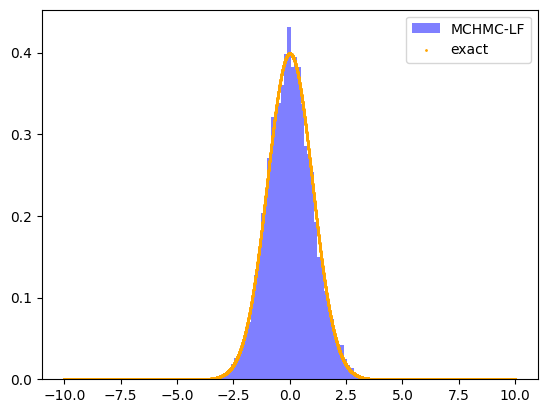

In [27]:
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 0, cov[0,0]) 

X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/gaussian_hamiltonian_LF.svg', format='svg')
plt.show()

## Minimal norm

In [6]:
row = df[(df['algorithm'] == 'MCHMC_bounces') & (df['integ_scheme'] == 'minimal_norm')]
eps = row['eps'].values[0]
L = row['L'].values[0]

X, ess_mean, ess_min, ess_truth = MCHMC.MCHMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.minimal_norm, cov=cov)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 125.87it/s]


In [7]:
print(f'ESS with MCHMC-bounces and MN integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCHMC-bounces and MN integrator 
 mean: 0.076 
 min: 0.039 
 ground truth: 0.076


In [9]:
x = np.linspace(-10, 10, 10000)
pdf = norm.pdf(x, 0, cov[0,0]) 

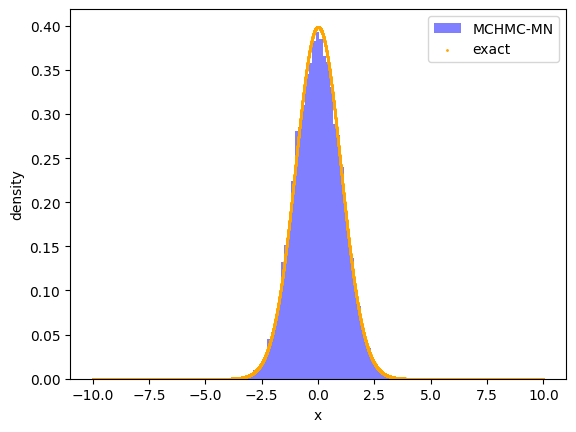

In [11]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCHMC-MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/gaussian_hamiltonian_MN.svg', format='svg')
plt.show()

------
# Langevin Like Hamiltonian Monte Carlo 
## Leapfrog

In [28]:
row = df[(df['algorithm'] == 'MCLMC') & (df['integ_scheme'] == 'leapfrog')]
eps = row['eps'].values[0]
eps = torch.tensor(eps, device=utils.choose_device())
L = row['L'].values[0]
L = torch.tensor(L, device=utils.choose_device())

X, ess_mean, ess_min, ess_truth = MCLMC.MCLMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.leapfrog, cov=cov)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 156.52it/s]


In [29]:
print(f'ESS with MCLMC and LF integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCLMC and LF integrator 
 mean: 0.023 
 min: nan 
 ground truth: 0.028


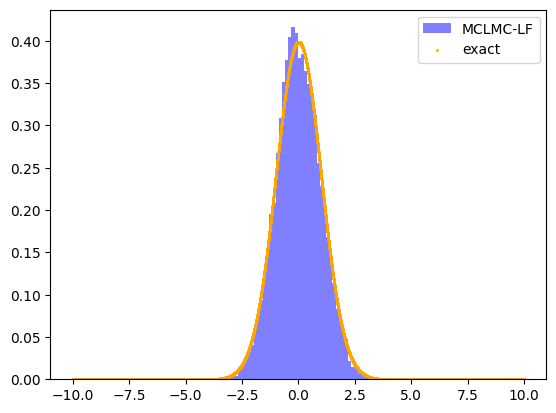

In [30]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC-LF')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/gaussian_langevin_LF.svg', format='svg')
plt.show()

## Minimal Norm

In [12]:
row = df[(df['algorithm'] == 'MCLMC') & (df['integ_scheme'] == 'minimal_norm')]
eps = row['eps'].values[0]
eps = torch.tensor(eps, device=utils.choose_device())
L = row['L'].values[0]
L = torch.tensor(L, device=utils.choose_device())

X, ess_mean, ess_min, ess_truth = MCLMC.MCLMC_chain(n_chains, d, fn, L, eps, int_scheme=integ.minimal_norm, cov=cov)

100%|████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 121.04it/s]


In [13]:
print(f'ESS with MCLMC and MN integrator \n mean: {ess_mean:.3f} \n min: {ess_min:.3f} \n ground truth: {ess_truth:.3f}')

ESS with MCLMC and MN integrator 
 mean: 0.076 
 min: 0.039 
 ground truth: 0.076


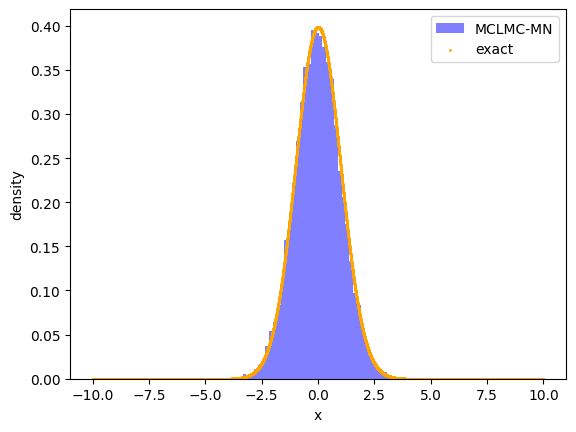

In [14]:
X = X.to("cpu").detach().numpy()
plt.hist(X[:,0], density=True, alpha=0.5, bins=50, color='blue', label='MCLMC-MN')
plt.scatter(x, pdf, color='orange', s=1, label='exact')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.savefig('./plots/gaussian_langevin_MN.svg', format='svg')
plt.show()